--- 1. Data Processing (Oscillators) ---
--- 2. Setting up SAC Agent ---
Using cpu device
--- 3. Training (80000 steps) ---


/var/folders/04/4l6xjjw976j6gj89kg1qrrf80000gn/T/ipykernel_28881/761180698.py:51: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(self.tickers, start=self.start_date, end=self.end_date, progress=False)


---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 59       |
|    time_elapsed    | 150      |
|    total_timesteps | 8936     |
| train/             |          |
|    actor_loss      | -14.1    |
|    critic_loss     | 0.027    |
|    ent_coef        | 0.413    |
|    ent_coef_loss   | -1.49    |
|    learning_rate   | 0.0001   |
|    n_updates       | 8835     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 61       |
|    time_elapsed    | 291      |
|    total_timesteps | 17872    |
| train/             |          |
|    actor_loss      | -14.1    |
|    critic_loss     | 0.0468   |
|    ent_coef        | 0.169    |
|    ent_coef_loss   | -2.97    |
|    learning_rate   | 0.0001   |
|    n_updates       | 17771    |
---------------------------------
---------------------------------
| time/       

/var/folders/04/4l6xjjw976j6gj89kg1qrrf80000gn/T/ipykernel_28881/761180698.py:51: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(self.tickers, start=self.start_date, end=self.end_date, progress=False)



MEAN REVERSION AGENT REPORT (SPY)
Total Return: 0.13%
Final Balance: $100,126.43


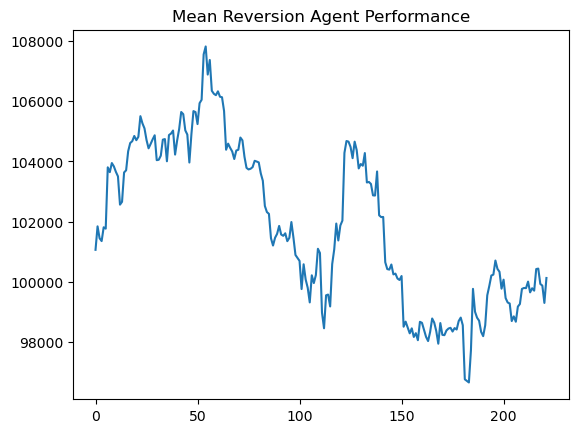

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import torch
import torch.nn as nn
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import matplotlib.pyplot as plt

# ==========================================
# 1. CONFIGURATION (SCALPER PROFILE)
# ==========================================
CONFIG = {
    "TICKERS": ["SPY", "QQQ", "IWM", "^VIX"], # Added IWM (Small caps chop more)
    "TARGET_ASSET": "SPY",
    "START_DATE": "2015-01-01",
    "END_DATE": "2023-12-31",
    "TEST_START_DATE": "2024-01-02",
    
    # Feature Engineering (Oscillators)
    "WINDOW_SIZE": 10,         # Shorter memory than Trend Agent
    "BB_STD": 2.0,             # Bollinger Band Standard Deviations
    
    # RL Environment
    "INITIAL_BALANCE": 100000,
    "TRADING_FEES": 0.0005,    # 5 bps
    
    # Reward: REALIZED PNL (Scalping focus)
    "REWARD_SCALING": 10.0,
    
    # SAC Agent Settings (Off-Policy, Entropy Maximization)
    "LEARNING_RATE": 1e-4,     # Slower, more precise
    "BUFFER_SIZE": 100000,
    "BATCH_SIZE": 256,
    "ENT_COEF": "auto",        # Automatically tune exploration
    "TRAINING_TIMESTEPS": 80000
}

# ==========================================
# 2. MEAN REVERSION DATA PIPELINE
# ==========================================
class DataProcessor:
    def __init__(self, tickers, start_date, end_date):
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        
    def download_data(self):
        data = yf.download(self.tickers, start=self.start_date, end=self.end_date, progress=False)
        if isinstance(data.columns, pd.MultiIndex):
            if 'Close' in data.columns.levels[0]:
                data = data.xs('Close', level=0, axis=1)
            elif 'Adj Close' in data.columns.levels[0]:
                data = data.xs('Adj Close', level=0, axis=1)
        if isinstance(data, pd.Series): data = data.to_frame()
        return data

    def add_oscillators(self, df, target_ticker):
        if df.empty or target_ticker not in df.columns: return pd.DataFrame()
        df = df.copy()
        
        # 1. Bollinger Bands (The Core of Mean Reversion)
        sma = df[target_ticker].rolling(window=20).mean()
        std = df[target_ticker].rolling(window=20).std()
        df['bb_upper'] = sma + (std * CONFIG['BB_STD'])
        df['bb_lower'] = sma - (std * CONFIG['BB_STD'])
        
        # Feature: %B (Where is price relative to bands?)
        # > 1.0 = Overbought, < 0.0 = Oversold
        df['pct_b'] = (df[target_ticker] - df['bb_lower']) / (df['bb_upper'] - df['bb_lower'])
        
        # Feature: Band Width (Volatility compression/expansion)
        df['bb_width'] = (df['bb_upper'] - df['bb_lower']) / sma
        
        # 2. RSI (Fast)
        delta = df[target_ticker].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=7).mean() # Faster window (7)
        loss = (-delta.where(delta < 0, 0)).rolling(window=7).mean()
        rs = gain / loss
        df['rsi'] = 100 - (100 / (1 + rs))
        
        # 3. Distance from Moving Average (Z-score proxy)
        df['dist_ma'] = (df[target_ticker] - sma) / (std + 1e-8)
        
        # Returns for PnL calc
        df['returns'] = df[target_ticker].pct_change()
        
        df.dropna(inplace=True)
        return df

    def get_processed_data(self, target_ticker):
        df = self.download_data()
        df = self.add_oscillators(df, target_ticker)
        
        # Features specifically for Mean Reversion
        features = ['returns', 'pct_b', 'bb_width', 'rsi', 'dist_ma']
        return df[features].fillna(0)

# ==========================================
# 3. SCALPING ENVIRONMENT
# ==========================================
class MeanReversionEnv(gym.Env):
    def __init__(self, df, config):
        super(MeanReversionEnv, self).__init__()
        self.df = df
        self.config = config
        self.window_size = config['WINDOW_SIZE']
        self.n_features = df.shape[1]
        
        # Action: Continuous [-1, 1]
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        # Observation: Flattened window (MLP friendly, no Transformer needed here)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, 
            shape=(self.window_size * self.n_features,), 
            dtype=np.float32
        )
        
        self.current_step = self.window_size
        self.balance = config['INITIAL_BALANCE']
        self.portfolio_value = self.balance
        self.history = []

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = self.window_size
        self.balance = self.config['INITIAL_BALANCE']
        self.portfolio_value = self.balance
        self.history = []
        return self._get_observation(), {}

    def _get_observation(self):
        # Flatten the window for MLP processing
        obs = self.df.iloc[self.current_step - self.window_size : self.current_step].values
        return obs.flatten().astype(np.float32)

    def step(self, action):
        action = np.clip(action, -1, 1)[0]
        
        if self.current_step >= len(self.df):
            return self._get_observation(), 0, True, False, {}
            
        market_return = self.df.iloc[self.current_step]['returns']
        
        # Cost Calculation
        prev_action = self.history[-1]['action'] if len(self.history) > 0 else 0
        turnover = abs(action - prev_action)
        cost = turnover * self.config['TRADING_FEES']
        
        strategy_return = (action * market_return) - cost
        self.portfolio_value *= (1 + strategy_return)
        
        # --- REWARD: MEAN REVERSION LOGIC ---
        # 1. Pure PnL Reward (We want absolute profit per step)
        reward = strategy_return * self.config['REWARD_SCALING']
        
        # 2. Volatility Penalty (But lighter than Trend Agent, we accept some chop)
        reward -= 0.1 * (strategy_return**2)
        
        # 3. Reversal Bonus (Heuristic)
        # If RSI is Overbought (>70) and we Sell (Action < 0), small bonus
        # If RSI is Oversold (<30) and we Buy (Action > 0), small bonus
        current_rsi = self.df.iloc[self.current_step]['rsi']
        if current_rsi > 70 and action < -0.5:
            reward += 0.1
        elif current_rsi < 30 and action > 0.5:
            reward += 0.1
            
        self.current_step += 1
        terminated = self.current_step >= len(self.df) - 1
        
        info = {
            'portfolio_value': self.portfolio_value,
            'return': strategy_return,
            'action': action
        }
        self.history.append(info)
        
        return self._get_observation(), reward, terminated, False, info

# ==========================================
# 4. EXECUTION
# ==========================================
def run_mean_reversion():
    print("--- 1. Data Processing (Oscillators) ---")
    data_loader = DataProcessor(CONFIG['TICKERS'], CONFIG['START_DATE'], CONFIG['END_DATE'])
    train_df = data_loader.get_processed_data(CONFIG['TARGET_ASSET'])
    
    if train_df.empty: return

    print("--- 2. Setting up SAC Agent ---")
    # SAC works best with normalized observations
    env = DummyVecEnv([lambda: MeanReversionEnv(train_df, CONFIG)])
    env = VecNormalize(env, norm_obs=True, norm_reward=False, clip_obs=10.)
    
    # SAC (Soft Actor Critic) - Ideal for continuous control with high entropy
    model = SAC(
        "MlpPolicy", 
        env, 
        verbose=1,
        learning_rate=CONFIG['LEARNING_RATE'],
        buffer_size=CONFIG['BUFFER_SIZE'],
        batch_size=CONFIG['BATCH_SIZE'],
        ent_coef=CONFIG['ENT_COEF']
    )
    
    print(f"--- 3. Training ({CONFIG['TRAINING_TIMESTEPS']} steps) ---")
    model.learn(total_timesteps=CONFIG['TRAINING_TIMESTEPS'])
    
    print("--- 4. Backtesting ---")
    test_loader = DataProcessor(CONFIG['TICKERS'], CONFIG['TEST_START_DATE'], "2025-01-01")
    test_df = test_loader.get_processed_data(CONFIG['TARGET_ASSET'])
    
    if test_df.empty: return

    test_env = DummyVecEnv([lambda: MeanReversionEnv(test_df, CONFIG)])
    test_env = VecNormalize(test_env, norm_obs=True, norm_reward=False, clip_obs=10.)
    test_env.obs_rms = env.obs_rms # Sync stats
    test_env.training = False
    
    obs = test_env.reset()
    history = []
    
    while True:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done_array, info_array = test_env.step(action)
        history.append(info_array[0])
        if done_array[0]: break
        
    # Analysis
    res = pd.DataFrame(history)
    total_ret = (res['portfolio_value'].iloc[-1] / CONFIG['INITIAL_BALANCE']) - 1
    
    print("\n" + "="*40)
    print(f"MEAN REVERSION AGENT REPORT ({CONFIG['TARGET_ASSET']})")
    print("="*40)
    print(f"Total Return: {total_ret:.2%}")
    print(f"Final Balance: ${res['portfolio_value'].iloc[-1]:,.2f}")
    
    plt.plot(res['portfolio_value'])
    plt.title("Mean Reversion Agent Performance")
    plt.show()

if __name__ == "__main__":
    torch.set_num_threads(8)
    run_mean_reversion()